## [In progress...] FEM for two-dimensional Poisson equation

### Problem formulation
(Initially follows Langtangen, Logg: Solving PDEs in Python - The FEniCS Tutorial I)

Our goal is to solve the Poisson equation
$$ - \Delta \phi(x, y) = f(x, y), (x, y) \in \Omega $$
for some boundary condition
$$ \phi(x, y) = \phi_0(x, y), \forall (x, y) \in \partial \Omega $$

### Weak formulation of the problem
When multiplying a test function $v(x, y)$ (which is differentiable in both arguments, and vanishes on $\partial \Omega$) to both sides of the Poisson equation, and subsequently integrating over all of $\Omega$, we can apply Gauss' theorem to obtain the following equation:
$$ \int_{\Omega} \nabla \phi(x, y) \nabla v(x, y) dx dy = \int_{\Omega} f(x, y) v(x, y) dx dy

### Interpolation in two dimensions
To interpolate a function $f(x, y)$ with piecewise linear functions in two dimensions, we need to triangulate the domain $\Omega$ using triangles that each connect three nodes $\{(x_i, y_i)\}_{i=1}^M$. One such triangle, which connects nodes $\{(x_i, y_i)\}_{i \in I}$, where $I$ is a set of three distinct indices, is fully described by the function
$$ p(x, y) = ax + by + c $$
that must satisfy $p(x_i, y_i) = f(x_i, y_i), \forall i \in I$. In other words, we can determine this function (or much rather the coefficients $a, b, c$) by solving the following linear system of equations:
$$ \begin{bmatrix} x_{I_1} & y_{I_1} & 1 \\ x_{I_2} & y_{I_2} & 1 \\ x_{I_3} & y_{I_3} & 1 \end{bmatrix}
   \begin{bmatrix} a \\ b \\ c \end{bmatrix} 
   = \begin{bmatrix} f(x_{I_1}, y_{I_1}) \\ f(x_{I_2}, y_{I_2}) \\ f(x_{I_3}, y_{I_3}) \end{bmatrix} $$
Therefore, we summarize that the interpolating triangle is given by
$$ p(x, y) = \left( \begin{bmatrix} x_{I_1} & y_{I_1} & 1 \\ x_{I_2} & y_{I_2} & 1 \\ x_{I_3} & y_{I_3} & 1 \end{bmatrix}^{-1}
             \begin{bmatrix} f(x_{I_1}, y_{I_1}) \\ f(x_{I_2}, y_{I_2}) \\ f(x_{I_3}, y_{I_3}) \end{bmatrix} \right)^T
             \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} $$
To confirm this, I will quickly verify it using a simple example:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

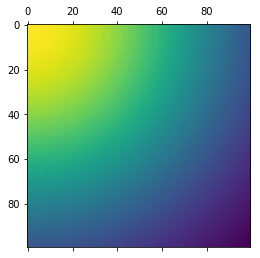

In [9]:
f = lambda x, y: np.exp( - x**2 - y**2)
f_grid = np.array(np.frompyfunc(f, 2, 1).outer(np.linspace(0, 1, 100), np.linspace(0, 1, 100)), dtype=float)
plt.matshow(f_grid)

In [10]:
def p(x, y, x_nodes, y_nodes, f_nodes):
    A = np.array([x_nodes, y_nodes, np.ones(len(x_nodes))]).T
    b = np.array(f_nodes).T
    coeff = np.linalg.solve(A, b)
    return np.dot(coeff, [x, y, 1])

[1.0, 0.36787944117144233, 0.36787944117144233]
[1.0, 0.36787944117144233, 0.36787944117144233]


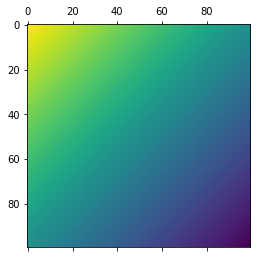

In [11]:
x_nodes = [0, 1, 0]
y_nodes = [0, 0, 1]
f_nodes = list(map(f, x_nodes, y_nodes))
p_xy = lambda x, y: p(x, y, x_nodes, y_nodes, f_nodes)
f_tri = np.array(np.frompyfunc(p_xy, 2, 1).outer(np.linspace(0, 1, 100), np.linspace(0, 1, 100)), dtype=float)
plt.matshow(f_tri)
p_nodes = list(map(p_xy, x_nodes, y_nodes))
print(f_nodes)
print(p_nodes)

### Lagrange interpolation in two dimensions
$$ \varphi_{ij}(x, y) = \prod_{k \neq i, n \neq j} \frac{x-x_k}{x_i-x_k} \frac{y-y_n}{y_j-y_n} $$
$$ \Pi_{kn} f(x, y) = \sum_k \sum_n f(x_k, y_n) \varphi_{kn}(x, y) $$

We now need to discretize our domain into a mesh. Let's consider a square:

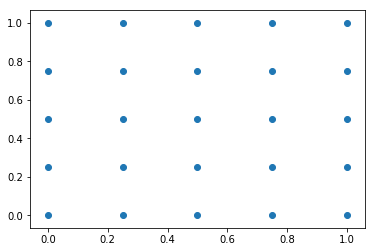

In [12]:
X, Y = np.meshgrid(np.linspace(0, 1, 5), np.linspace(0, 1, 5))
X_nodes, Y_nodes = X.ravel(), Y.ravel()
plt.scatter(X_nodes, Y_nodes)